In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [ ]:

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

In [ ]:
from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray"

In [ ]:
print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...


In [ ]:
train_df = glob.glob("/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/train/**/*.jpeg")
test_df = glob.glob("/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))


The datasets were succesfully loaded...


In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5272 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


In [ ]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4313
The number of non-pneumonia images is 1599


NORMAL


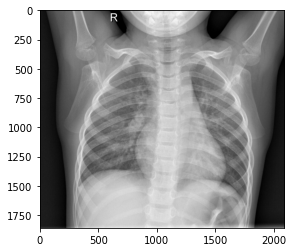

In [ ]:
normal_lung_image = load_img("/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/test"
validation_dir = "/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/val"

In [ ]:
train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5272 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
#RESNET50V2 MODEL

In [ ]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False
    
base_model2.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model3.fit_generator(train_set, epochs = 50, validation_data = validation_set, steps_per_epoch = 100)

Epoch 1/50
100/100 [==============================] - 411s 4s/step - loss: 0.4860 - accuracy: 0.8037 - val_loss: 0.2744 - val_accuracy: 0.8125
Epoch 2/50
100/100 [==============================] - 280s 3s/step - loss: 0.2834 - accuracy: 0.8832 - val_loss: 0.7174 - val_accuracy: 0.7500
Epoch 3/50
100/100 [==============================] - 212s 2s/step - loss: 0.2687 - accuracy: 0.8800 - val_loss: 0.2768 - val_accuracy: 0.8750
Epoch 4/50
100/100 [==============================] - 154s 2s/step - loss: 0.2209 - accuracy: 0.9044 - val_loss: 0.5459 - val_accuracy: 0.7500
Epoch 5/50
100/100 [==============================] - 123s 1s/step - loss: 0.1823 - accuracy: 0.9212 - val_loss: 0.3525 - val_accuracy: 0.8750
Epoch 6/50
100/100 [==============================] - 102s 1s/step - loss: 0.1991 - accuracy: 0.9121 - val_loss: 0.2340 - val_accuracy: 0.8125
Epoch 7/50
100/100 [==============================] - 82s 816ms/step - loss: 0.1763 - accuracy: 0.9271 - val_loss: 0.3488 - val_accuracy: 0.81

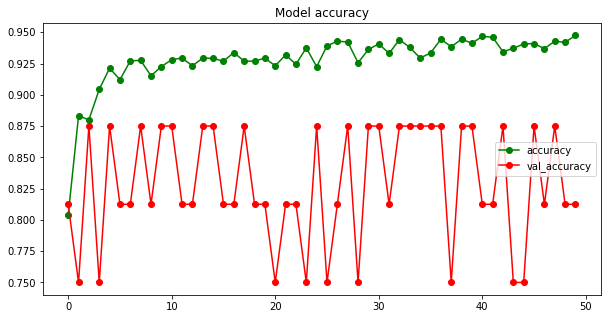

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

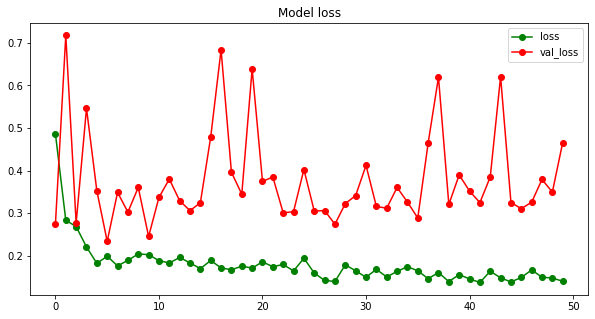

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [ ]:
test_loss, test_accuracy = model3.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

39/50 [======================>.......] - ETA: 41s - loss: 0.2334 - accuracy: 0.9087

50/50 [==============================] - 143s 3s/step - loss: 0.2334 - accuracy: 0.9087
The testing accuracy is:  90.86538553237915 %
The testing loss is:  23.341836035251617 %


In [ ]:
new_image_path = "/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/test/NORMAL/IM-0009-0001.jpeg"
test_image = image.load_img(new_image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
#test_image = np.reshape(test_image, (1, 224, 224, 3))
test_image = test_image / 255


result = model3.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = "N O R M A L"
else:
    prediction = "P N E U M O N I A"

print(prediction)

1/1 [==============================] - 2s 2s/step
P N E U M O N I A


In [ ]:
model3.save("Pneumonia_RESNET50V2final.h5")


In [ ]:

model3 = tf.keras.Model(model3)
model3.save_weights("/content")


In [ ]:
model_loaded = tensorflow.keras.models.load_model("/content/Pneumonia_RESNET50V2final.h5")
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,837,441
Trainable params: 272,641
Non-t

1/1 [==============================] - 9s 9s/step
This image is 92.295 percent P N E U M O N I A


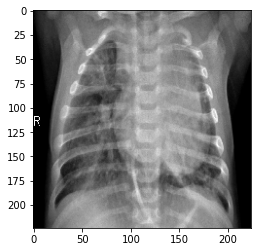

In [ ]:

def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("/content/Pneumonia_RESNET50V2final.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100 
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))
     
 
# call and use the function
image_prediction("/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")

In [ ]:
test_dir = "/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/chest_xray/test"
test_data, test_labels = [], []

In [ ]:
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (224, 224))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

----------C o n f u s i o n   m a t r i x-----------


20/20 [==============================] - 2s 88ms/step


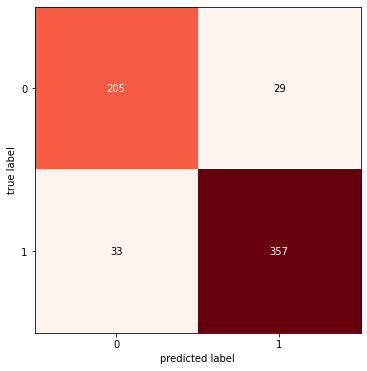

In [ ]:

print("----------C o n f u s i o n   m a t r i x-----------\n\n")
predictions = model_loaded.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = matplotlib.pyplot.cm.Reds)
plt.show()


In [ ]:
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 90.06410256410257%
Precision: 92.48704663212435%
Recall: 91.53846153846153%
F1-score: 92.0103092783505
